In [ ]:
# 1) Metocean Data Acquisition from ERA5 Dataset
# Importing necessary libraries
import cdsapi
import os

# Initialize the Climate Data Store API client -- Make sure to have an account with the Copernicus Climate Data Store at https://cds.climate.copernicus.eu, which is necessary to access ERA5 data.
c = cdsapi.Client()

# TODO: Update the output_directory with your specific path.
output_directory = ''  # TODO Set the directory where the files will be saved, e.g. 'C:\\Users\\era5_.nc_files'

# Looping through the years to retrieve data
for year in range(1972, 2023): # TODO Adjust the loop range according to year of analysis interest 
    print(year)
    # Constructing the filename for each year's data
    output_filename = os.path.join(output_directory, f'era5_data_{year}.nc') # could be named as; f'era5_data_humboltbayport_{year}.nc') -- depending on the selected location for data collection, port or wea.

    # Retrieving data from the ERA5 dataset -- modify this section with desired parameter data and range collection
    c.retrieve(
        'reanalysis-era5-single-levels',
        {
            'product_type': 'reanalysis',
            'variable': [
                '10m_u_component_of_wind', '10m_v_component_of_wind',
                'significant_height_of_wind_waves',
            ],
            'year': str(year),
            'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'],
            'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31'],
            'time': ['00:00', '01:00', '02:00', '03:00', '04:00', '05:00', '06:00', '07:00', '08:00', '09:00', '10:00', '11:00', '12:00', '13:00', '14:00', '15:00', '16:00', '17:00', '18:00', '19:00', '20:00', '21:00', '22:00', '23:00'],
            'area': [],  # TODO Specify the geographical area (lat/lon), such as [35.25, -120.55, 35.15, -120.5,]
            'format': 'netcdf',
        },
        output_filename
    )

# Confirmation message after downloading the data
print(f'Data downloaded to {output_directory}')

In [ ]:
# 2) Processing and Combining ERA5 Metocean .nc File Data into Excel File

# Importing necessary libraries
import os
import pandas as pd
import netCDF4 as nc
import datetime

# TODO: Update the nc_files_directory with the path where your collected .nc files are located.
nc_files_directory = 'path_to_your_nc_files_directory'  # e.g., 'C:\\Users\\era5_.nc_files'

# Create an empty DataFrame to store the combined data
combined_df = pd.DataFrame()

# Loop through the NetCDF files for collected data year ranges, e.g., 1972 to 2023
for year in range(1972, 2023):
    # Construct the file path for each year's data
    # TODO: Customize the filename based on your naming convention and location
    file_path = os.path.join(nc_files_directory, f"era5_data_{year}.nc")

    # Check if the file exists
    if not os.path.exists(file_path):
        continue

    # Open the NetCDF file
    data = nc.Dataset(file_path, 'r')

    # Extract and process the data from the NetCDF file
    # TODO: Adjust variable names as needed based on your NetCDF file structure. (the first element for the second and third dimensions of u10, v10, and shww selected)
    times = data.variables['time'][:]
    u10 = data.variables['u10'][:, 0, 0]
    v10 = data.variables['v10'][:, 0, 0]
    shww = data.variables['shww'][:, 0, 0]

    # Calculate wind speed at 150m from the 10m level using the shear power law
    wind_speed_10m = (u10**2 + v10**2)**0.5
    wind_speed_150m = wind_speed_10m * (150/10)**0.14

    # Flatten the arrays for processing
    times = times.flatten()
    wind_speed_10m = wind_speed_10m.flatten()
    wind_speed_150m = wind_speed_150m.flatten()
    shww = shww.flatten()

    # Convert the time data to datetime format
    # Adjust ref_time based on ERA5 reference time (e.g., 1900 or 1970)
    ref_time = datetime.datetime(1900, 1, 1)  
    times = [ref_time + datetime.timedelta(hours=int(t)) for t in times]

    # Create a DataFrame for the current year's data
    year_df = pd.DataFrame({
        'Time (h)': times,
        'Wind Speed at 10m (m/s)': wind_speed_10m,
        'Wind Speed at 150m (m/s)': wind_speed_150m,
        'Significant Wave Height (m)': shww
    })

    # Append the year's data to the combined DataFrame
    combined_df = pd.concat([combined_df, year_df], ignore_index=True)

# Save the combined data to an Excel file
# TODO: Customize the filename of the output Excel file
output_excel_file = 'combined_era5_data.xlsx'
combined_df.to_excel(os.path.join(nc_files_directory, output_excel_file), index=False)

print(f'Data from 1972 to 2022 exported to {output_excel_file}')

# Optional: Print variable keys of the last opened NetCDF file for verification
data = nc.Dataset(file_path, "r")
print(data.variables.keys())

In [2]:
# 3) Import Libraries and Load Data

# Importing necessary libraries for data analysis and visualization
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import xarray as xr
import math
from scipy.optimize import curve_fit 
import scipy.integrate as spi
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# TODO: Update the file path to the location of your Excel file.
file_path = 'path_to_your_excel_file'  # e.g. 'C:\\Users\\era5_files\\combined_era5_data.xlsx'
df = pd.read_excel(file_path)

# Display the first few rows of the data
print(df.head())

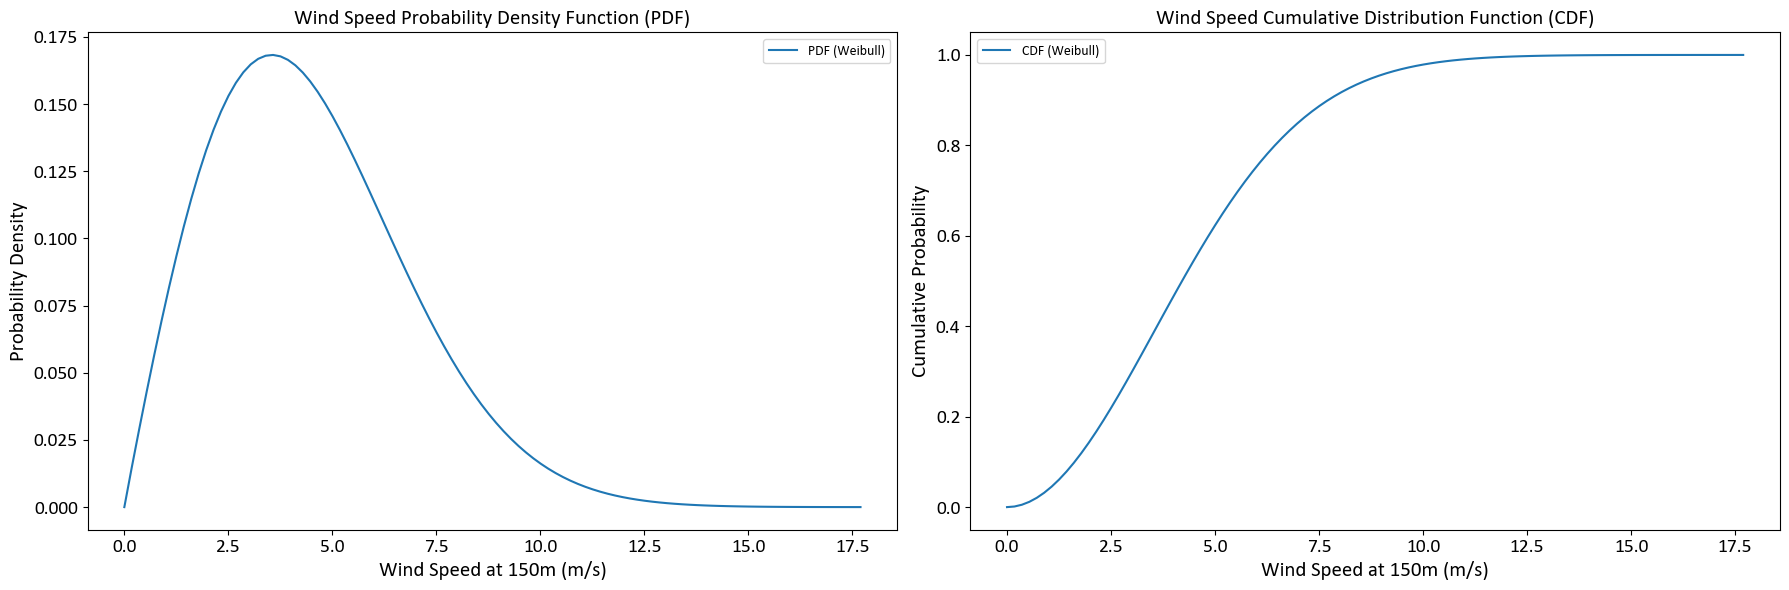

In [10]:
# 4) Statistical Analysis of Wind Speed Data Using Weibull Distribution

# Importing necessary libraries for statistical analysis and visualization
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Fit the Weibull distribution to wind speed data at 150m
# TODO: Ensure your DataFrame 'df' has a column 'Wind Speed at 150m (m/s)'
shape, loc, scale = stats.weibull_min.fit(df['Wind Speed at 150m (m/s)'], floc=0)

# Generate a range of wind speeds for plotting the PDF and CDF
x = np.linspace(0, df['Wind Speed at 150m (m/s)'].max(), 100)

# Setting custom font for the plots
plt.rcParams['font.family'] = 'Calibri'

# Calculate the Probability Density Function (PDF) and Cumulative Distribution Function (CDF)
pdf = stats.weibull_min.pdf(x, shape, loc, scale)
cdf = stats.weibull_min.cdf(x, shape, loc, scale)

# Create subplots for PDF and CDF
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
fig.set_size_inches(18, 6)  # Adjusting the figure size

# Plotting the PDF
ax1.plot(x, pdf, label='PDF (Weibull)')
ax1.set_xlabel('Wind Speed at 150m (m/s)', fontsize=15)
ax1.set_ylabel('Probability Density', fontsize=15)
ax1.set_title('Wind Speed Probability Density Function (PDF)', fontsize=15)
ax1.legend()
ax1.tick_params(axis='both', labelsize=14)

# Plotting the CDF
ax2.plot(x, cdf, label='CDF (Weibull)')
ax2.set_xlabel('Wind Speed at 150m (m/s)', fontsize=15)
ax2.set_ylabel('Cumulative Probability', fontsize=15)
ax2.set_title('Wind Speed Cumulative Distribution Function (CDF)', fontsize=15)
ax2.legend()
ax2.tick_params(axis='both', labelsize=14)

# Display the plots
plt.tight_layout()
plt.show()

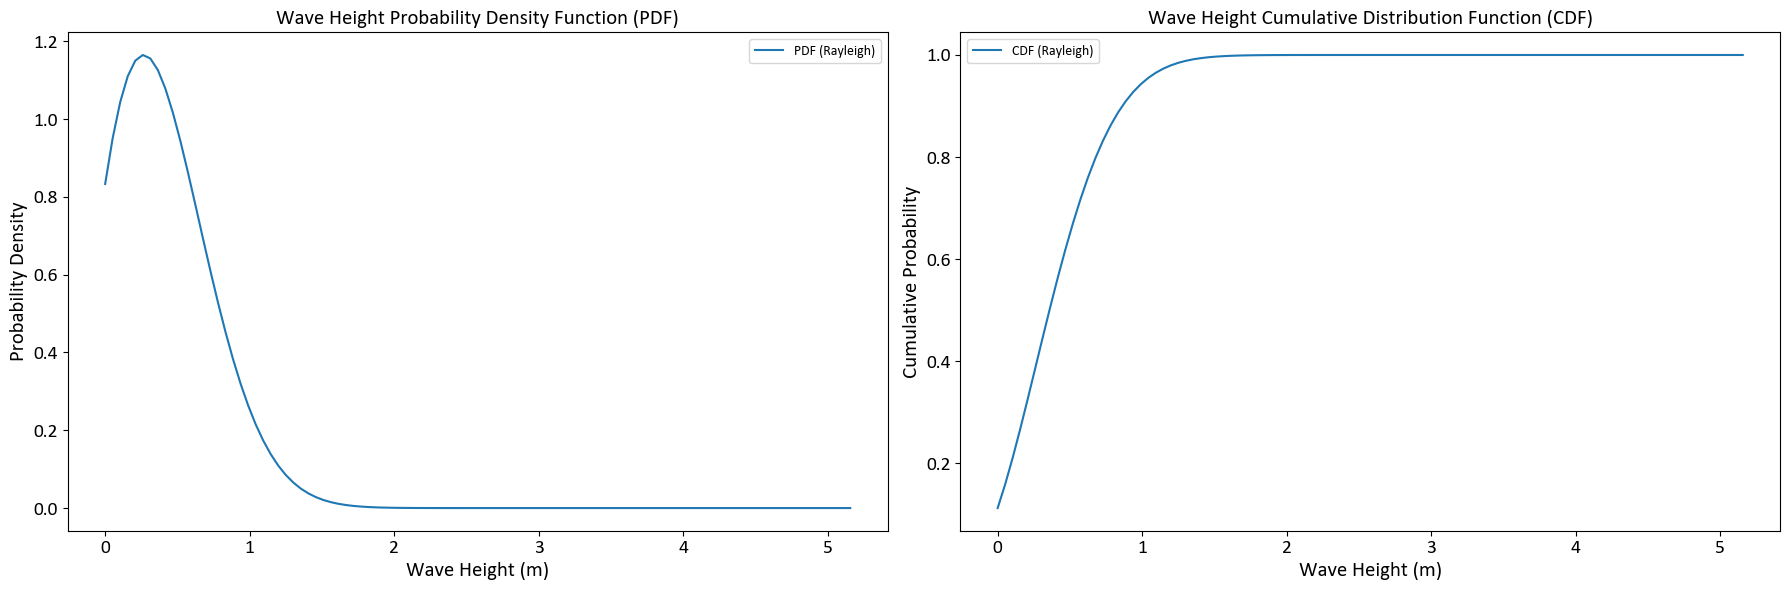

In [11]:
# 5) Statistical Analysis of Wave Height Data Using Rayleigh Distribution

# Importing necessary libraries for statistical analysis and visualization
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Fit a Rayleigh distribution to wave height data
# TODO: Ensure your DataFrame 'df' has a column 'Significant Wave Height (m)'
params = stats.rayleigh.fit(df['Significant Wave Height (m)'])
scale = params[0] 

# Setting custom font for the plots
plt.rcParams['font.family'] = 'Calibri'

# Generate a range of wave heights for plotting the PDF and CDF
x = np.linspace(0, df['Significant Wave Height (m)'].max(), 100)

# Calculate the Probability Density Function (PDF) and Cumulative Distribution Function (CDF)
pdf = stats.rayleigh.pdf(x, *params)
cdf = stats.rayleigh.cdf(x, *params)

# Create subplots for PDF and CDF
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
fig.set_size_inches(18, 6)  # Adjusting the figure size

# Plotting the PDF
ax1.plot(x, pdf, label='PDF (Rayleigh)')
ax1.set_xlabel('Wave Height (m)', fontsize=15)
ax1.set_ylabel('Probability Density', fontsize=15)
ax1.set_title('Wave Height Probability Density Function (PDF)', fontsize=15)
ax1.legend()
ax1.tick_params(axis='both', labelsize=14)

# Plotting the CDF
ax2.plot(x, cdf, label='CDF (Rayleigh)')
ax2.set_xlabel('Wave Height (m)', fontsize=15)
ax2.set_ylabel('Cumulative Probability', fontsize=15)
ax2.set_title('Wave Height Cumulative Distribution Function (CDF)', fontsize=15)
ax2.legend()
ax2.tick_params(axis='both', labelsize=14)

# Display the plots
plt.tight_layout()
plt.show()

In [ ]:
# 6) Detailed Monthly Analysis of Weather Conditions in 8-Hour Intervals

import pandas as pd
import numpy as np
import calendar

# Determine the range of years from the DataFrame
unique_years = df['Time (h)'].dt.year.unique()
years = range(min(unique_years), max(unique_years) + 1)
months = list(calendar.month_name)[1:]  # List of month names

# Initialize a dictionary to count conditions for each year and month
conditions_count = {(year, month): [0, 0, 0, 0, 0] for year in years for month in months}

def verify_condition(chunk, condition_met):
    """
    Additional verification for certain weather conditions. 
    If initially determined as WC4 or WC5, check against WC3 or WC4 respectively.
    """
    if condition_met == 3:  # If initially determined as WC4, check against WC3
        without_extreme = chunk.drop(chunk['Wind Speed at 150m (m/s)'].idxmax())
        without_extreme = without_extreme.drop(without_extreme['Significant Wave Height (m)'].idxmax())
        if conditions[2](without_extreme).all():
            return 2
    elif condition_met == 4:  # If initially determined as WC5, check against WC4
        without_extreme = chunk.drop(chunk['Wind Speed at 150m (m/s)'].idxmax())
        without_extreme = without_extreme.drop(without_extreme['Significant Wave Height (m)'].idxmax())
        if conditions[3](without_extreme).all():
            return 3
    return condition_met

def determine_condition(chunk):
    """
    Determine the weather condition for a given data chunk.
    """
    for idx, condition in enumerate(conditions):
        if condition(chunk).any():
            return verify_condition(chunk, idx) if idx in [3, 4] else idx
    return None

# Defining weather conditions as functions for flexibility
conditions = [
    lambda chunk: (chunk['Wind Speed at 150m (m/s)'] < 6) | (chunk['Significant Wave Height (m)'] < 0.9),
    lambda chunk: (chunk['Wind Speed at 150m (m/s)'] >= 6) & (chunk['Wind Speed at 150m (m/s)'] < 8) |
                  (chunk['Significant Wave Height (m)'] >= 0.9) & (chunk['Significant Wave Height (m)'] < 1),
    lambda chunk: (chunk['Wind Speed at 150m (m/s)'] >= 8) & (chunk['Wind Speed at 150m (m/s)'] < 12) |
                  (chunk['Significant Wave Height (m)'] >= 1) & (chunk['Significant Wave Height (m)'] < 1.5),
    lambda chunk: (chunk['Wind Speed at 150m (m/s)'] >= 12) & (chunk['Wind Speed at 150m (m/s)'] < 15) |
                  (chunk['Significant Wave Height (m)'] >= 1.5) & (chunk['Significant Wave Height (m)'] < 3.5),
    lambda chunk: (chunk['Wind Speed at 150m (m/s)'] >= 15) | (chunk['Significant Wave Height (m)'] >= 3.5)
]

# Data Pre-processing: Convert to numeric and handle non-numeric or negative values
for column in ['Wind Speed at 150m (m/s)', 'Significant Wave Height (m)']:
    df[column] = pd.to_numeric(df[column], errors='coerce').fillna(1).clip(lower=1)

# Analyze each month of each year
for year in years:
    for month in months:
        month_number = list(calendar.month_name).index(month)  # Convert month name to its number
        monthly_data = df[(df['Time (h)'].dt.year == year) & (df['Time (h)'].dt.month == month_number)]
        for i in range(0, len(monthly_data), 8):
            chunk = monthly_data.iloc[i:i+8]
            condition_met = determine_condition(chunk)
            if condition_met is not None:
                conditions_count[(year, month)][condition_met] += 1

# Convert the dictionary to a DataFrame
output_df = pd.DataFrame.from_dict(conditions_count, orient='index', columns=['WC_1', 'WC_2', 'WC_3', 'WC_4', 'WC_5'])
output_df.index = pd.MultiIndex.from_tuples(output_df.index, names=['Year', 'Month'])

# Save the analysis to an Excel file
output_path = 'path_to_save_monthly_weather_conditions.xlsx' #e.g. 'C:\\Users\\era5_files\\era5_monthly_weather_conditions.xlsx'
output_df.to_excel(output_path, engine='openpyxl')

# Optionally, print a preview of the DataFrame
print(output_df.head())

C:\Users\cceng\AppData\Local\Temp\ipykernel_9192\2558386083.py:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Year'].fillna(method='ffill', inplace=True)
C:\Users\cceng\AppData\Local\Temp\ipykernel_9192\2558386083.py:60: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


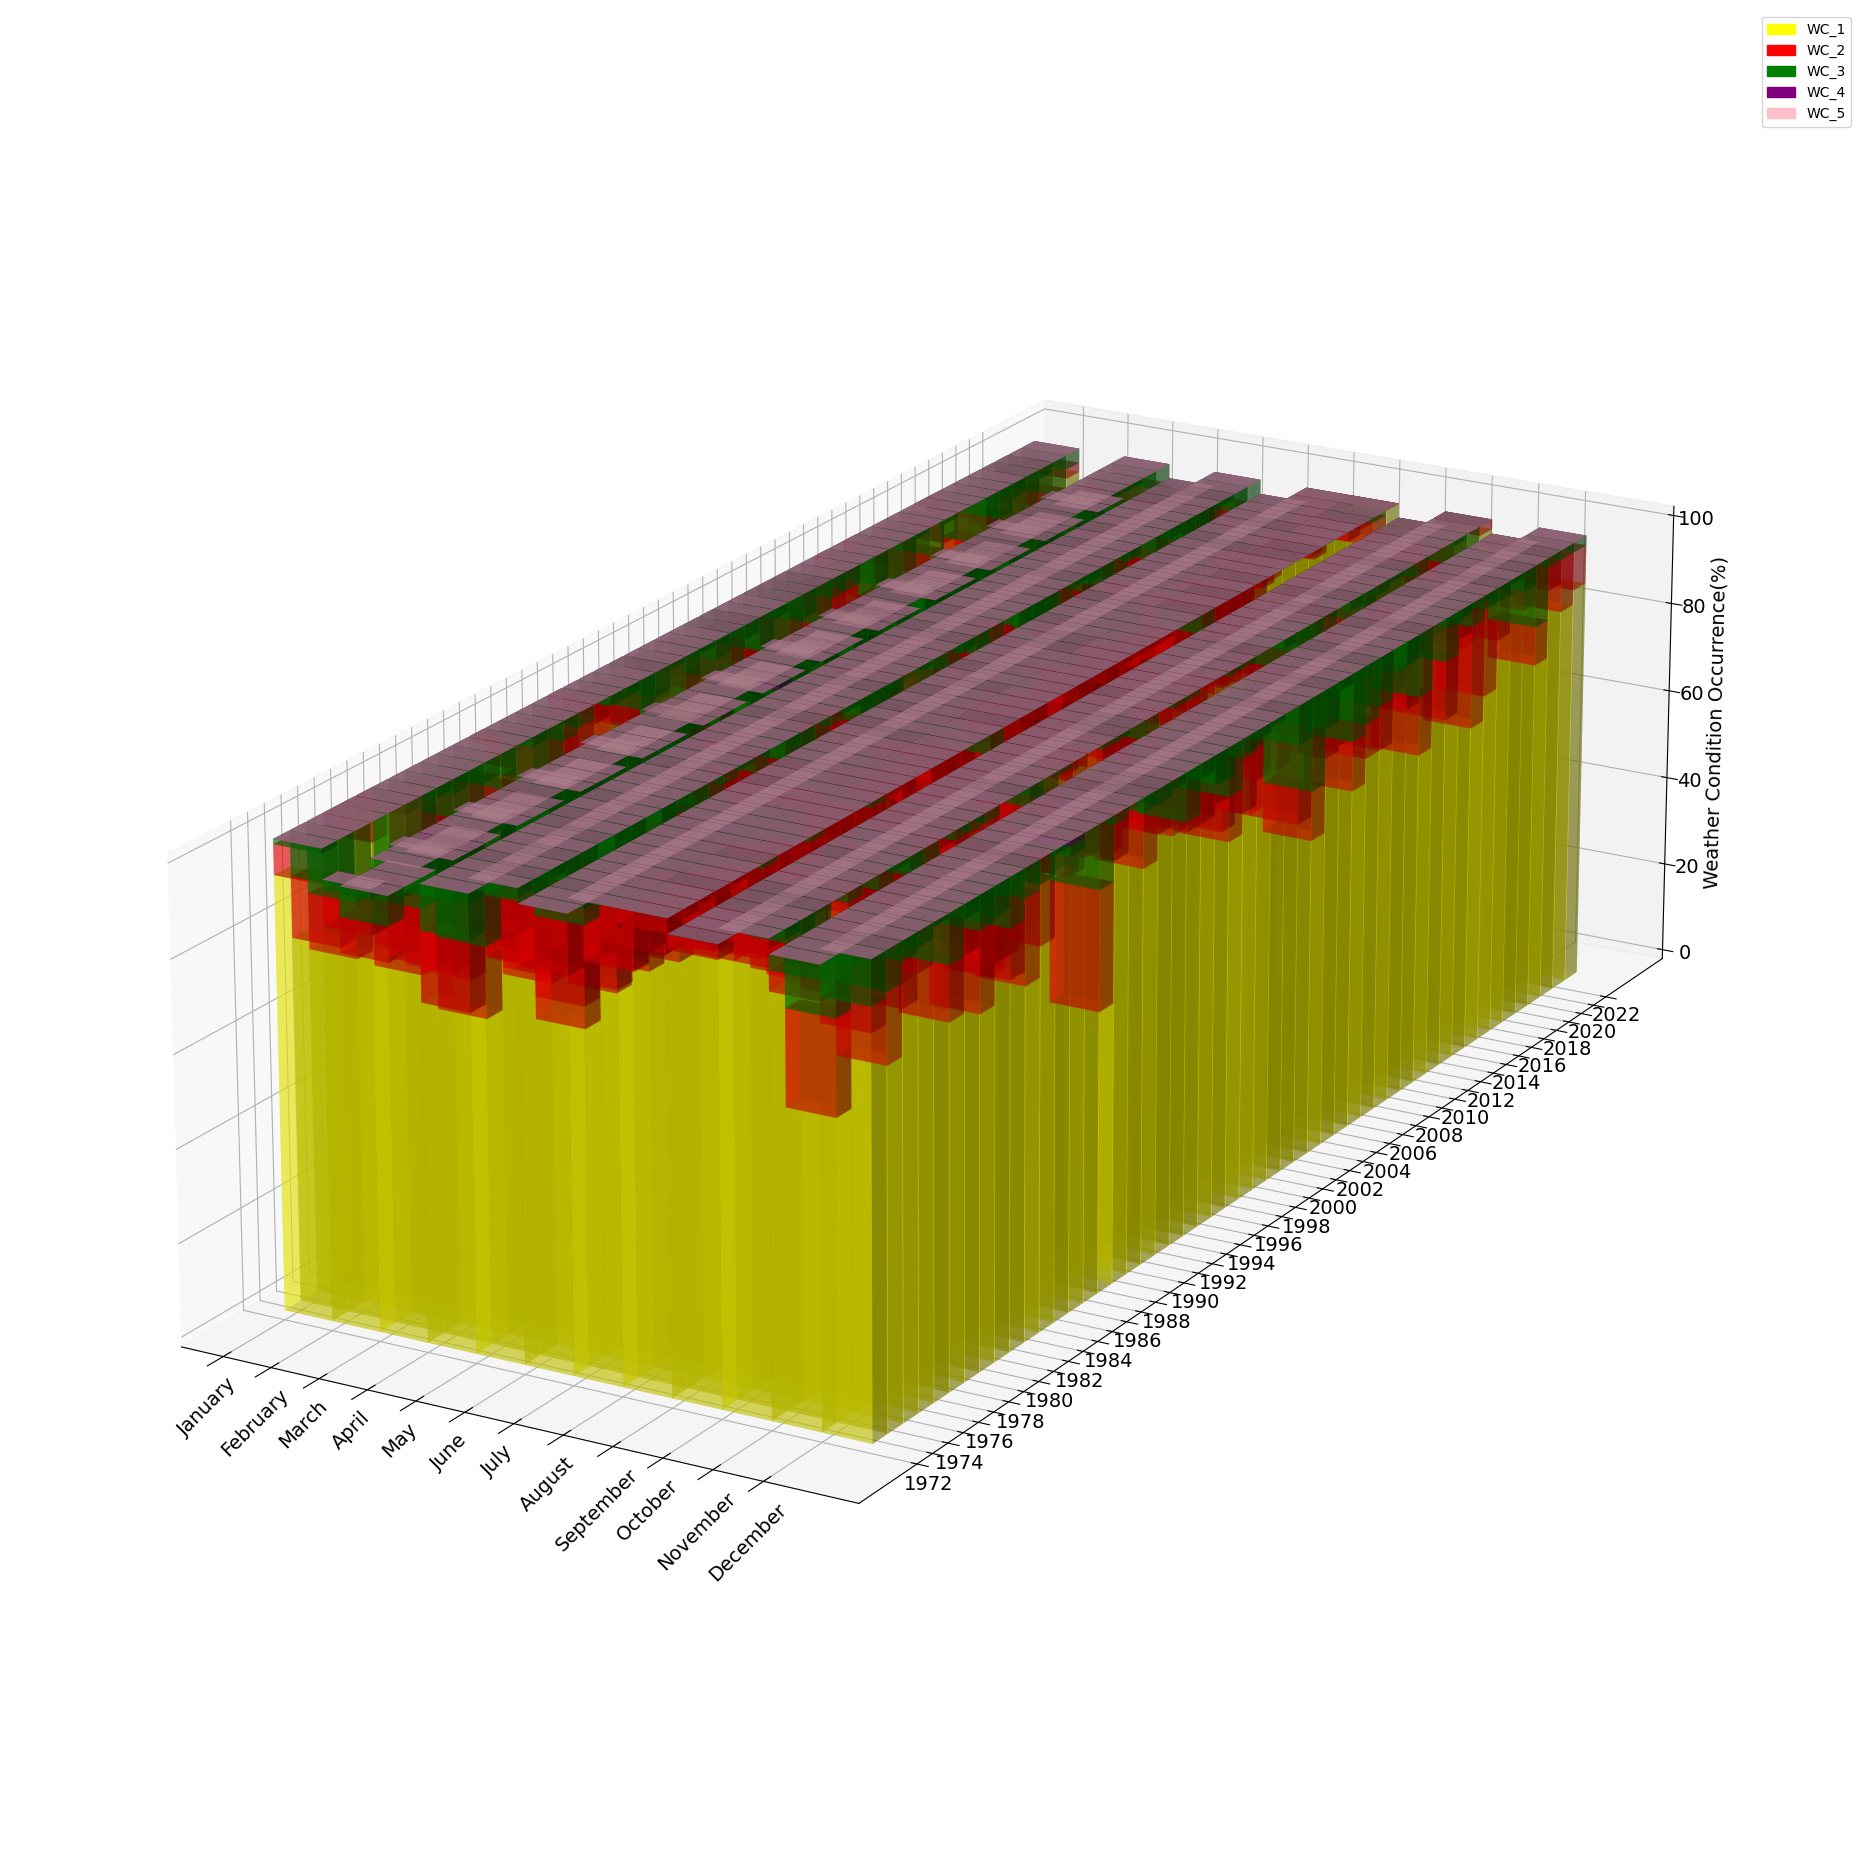

In [10]:
# 7) Visualization of Monthly Weather Condition Availabilities for Selected Location

# Importing necessary libraries for data handling and visualization
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

# Load the monthly weather condition data
file_path = 'path_to_save_monthly_weather_conditions.xlsx' #e.g. 'C:\\Users\\era5_files\\era5_monthly_weather_conditions.xlsx'
df = pd.read_excel(file_path, engine='openpyxl')

# Filling NaNs in the Year column to maintain continuity
df['Year'].fillna(method='ffill', inplace=True)

# Specify the desired order of months for consistent plotting
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']

# Convert 'Year' and 'Month' to categorical data types for ordered plotting
df['Year'] = df['Year'].astype(int).astype('category')
df['Month'] = pd.Categorical(df['Month'], categories=month_order, ordered=True)

# Prepare the data for 3D plotting
x = df['Month'].cat.codes.values
total_years = len(df['Year'].cat.categories)
y_space = np.linspace(0, total_years-1, total_years)  # distant y values for each year
y = np.repeat(y_space, len(df) // total_years)  # Repeat each year's data for each month

# Normalize the heights to percentages for better comparison
max_height = df[['WC_1', 'WC_2', 'WC_3', 'WC_4', 'WC_5']].sum(axis=1).max()
df[['WC_1', 'WC_2', 'WC_3', 'WC_4', 'WC_5']] = (df[['WC_1', 'WC_2', 'WC_3', 'WC_4', 'WC_5']] / max_height) * 100

# Generate labels for months and years
month_labels = df['Month'].cat.categories.tolist()
year_labels = [str(year) if year % 2 == 0 else '' for year in df['Year'].cat.categories.tolist()]

# Initialize 3D plot
fig = plt.figure(figsize=(24, 24))
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect([90,200,60])  # Adjust box aspect ratio

# Define colors for different weather conditions
colors = ['yellow', 'red', 'green', 'purple', 'pink']
columns = ['WC_1', 'WC_2', 'WC_3', 'WC_4', 'WC_5']

# Create stacked bar plots for each weather condition
previous_height = np.zeros_like(df['WC_1'].values)
for idx, col in enumerate(columns):
    heights = df[col].values
    ax.bar3d(x, y, previous_height, dx=1, dy=0.95, dz=heights, shade=True, color=colors[idx], alpha=0.4)
    previous_height += heights

# Add legend and labels for clarity
legend_patches = [Patch(color=colors[i], label=columns[i]) for i in range(len(columns))]
ax.legend(handles=legend_patches)
ax.set_zlabel('Weather Condition Occurrence (%)', fontsize=14)
ax.tick_params(axis='z', labelsize=14)
ax.set_xticks(np.arange(len(month_labels)))
ax.set_yticks(y_space)
ax.set_xticklabels(month_labels, rotation=45, fontsize=14)
ax.set_yticklabels(year_labels, fontsize=14)
ax.view_init(elev=20, azim=-60)  # Adjust viewing angle for better visualization

# Final layout adjustments and plot display
plt.tight_layout()
plt.show()

In [17]:
# 8) (IMPORTANT CELL IN METOCEAN DATA ANALYSIS FOR THE SIMULATION TOOL USE)
# 8-hour Interval-Based Weather Condition Analysis for Offshore Wind Installation Operations

import pandas as pd
import numpy as np
import calendar

# Print the DataFrame's column names to ensure required columns are present
print("DataFrame columns:", df.columns)

# Determine the range of years from the DataFrame
unique_years = df['Time (h)'].dt.year.unique()
years = range(min(unique_years), max(unique_years) + 1)

# Define weather conditions as lambda functions
conditions = [
    lambda chunk: (chunk['Wind Speed at 150m (m/s)'] < 6) | (chunk['Significant Wave Height (m)'] < 0.9),
    lambda chunk: (chunk['Wind Speed at 150m (m/s)'] >= 6) & (chunk['Wind Speed at 150m (m/s)'] < 8) |
                  (chunk['Significant Wave Height (m)'] >= 0.9) & (chunk['Significant Wave Height (m)'] < 1),
    lambda chunk: (chunk['Wind Speed at 150m (m/s)'] >= 8) & (chunk['Wind Speed at 150m (m/s)'] < 12) |
                  (chunk['Significant Wave Height (m)'] >= 1) & (chunk['Significant Wave Height (m)'] < 1.5),
    lambda chunk: (chunk['Wind Speed at 150m (m/s)'] >= 12) & (chunk['Wind Speed at 150m (m/s)'] < 15) |
                  (chunk['Significant Wave Height (m)'] >= 1.5) & (chunk['Significant Wave Height (m)'] < 3.5),
    lambda chunk: (chunk['Wind Speed at 150m (m/s)'] >= 15) | (chunk['Significant Wave Height (m)'] >= 3.5)
]

# Function to verify and refine weather condition categorization
def verify_condition(chunk, condition_met):
    """
    Additional verification for certain weather conditions. 
    If initially determined as WC4 or WC5, check against WC3 or WC4 respectively.
    """
    if condition_met == 3:  # If initially determined as WC4, check against WC3
        without_extreme = chunk.drop(chunk['Wind Speed at 150m (m/s)'].idxmax())
        without_extreme = without_extreme.drop(without_extreme['Significant Wave Height (m)'].idxmax())
        if conditions[2](without_extreme).all():
            return 2
    elif condition_met == 4:  # If initially determined as WC5, check against WC4
        without_extreme = chunk.drop(chunk['Wind Speed at 150m (m/s)'].idxmax())
        without_extreme = without_extreme.drop(without_extreme['Significant Wave Height (m)'].idxmax())
        if conditions[3](without_extreme).all():
            return 3
    return condition_met

def determine_condition(chunk):
    """
    Determine the weather condition for a given data chunk.
    """
    for idx, condition in enumerate(conditions):
        if condition(chunk).any():
            # Additional verification for WC4 and WC5
            if idx in [3, 4]:
                return verify_condition(chunk, idx)
            return idx
    return None

# Assuming 'df' is DataFrame containing the hourly weather data
# DataFrame should have columns 'Time (h)', 'Wind Speed at 150m (m/s)', 'Significant Wave Height (m)'

# Initialize a list to store data for interval-based weather condition analysis
output_data = []

# Iterate through the data in 8-hour intervals for each year
for year in years:
    yearly_data = df[df['Time (h)'].dt.year == year]
    for i in range(0, len(yearly_data), 8):
        chunk = yearly_data.iloc[i:i+8]
        if len(chunk) == 8:  # Ensure each chunk represents a full 8-hour interval
            start_time = chunk.iloc[0]['Time (h)']
            end_time = chunk.iloc[-1]['Time (h)']
            wc_category = 'WC_None'  # Default category if no condition is met
            condition_met = determine_condition(chunk)
            wc_category = f'WC_{condition_met + 1}' if condition_met is not None else wc_category
            output_data.append({'Start Time': start_time, 'End Time': end_time, 'WC_Category': wc_category})

# Convert the list to a DataFrame for better visualization and further analysis
output_wc_df = pd.DataFrame(output_data)

# Save the DataFrame to an Excel file for use in simulation tools
output_path = 'path_to_save_era5_metocean_catgories_in_8hr_intervals.xlsx' # e.g. 'C:\\Users\\era5_files\\era5_metocean_catgories_in_8hr_intervals.xlsx' 
output_wc_df.to_excel(output_path, index=False)

# Optionally, print a preview of the DataFrame for verification
print(output_wc_df.head())

#Note: If 'KeyError: 'Time (h)' error occurs, rerun the Cell 3 and try again.